Load the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
# path for desktop PC
sys.path.append(r'C:\Users\test\Masterarbeit')
# path for surface PC
#sys.path.append(r'C:\Users\Surface\Masterarbeit')

%matplotlib inline
# path for desktop PC
path = r"C:\Users\test\Masterarbeit\data\WZ_2_Feature_Engineered_Fynn6.xlsx"
# path for surface PC
#path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"

df = pd.read_excel(path)


Transformation Pipeline

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import prep
import importlib
importlib.reload(prep)

# set the target variable
target = 'C1_V01_delta_kan'
#print(df.columns)
# get the numerical features
data_num = df.drop(['C1_V01_delta_kan'], axis = 1, inplace=False)
#print(data_num.columns)
# get the target values
data_labels = df[target].to_numpy()

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test_prep, y_temp, y_test = train_test_split(data_num, data_labels, test_size= 0.2, random_state=42)
X_train_prep, X_val_prep, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

# use coustom function "cat_transform" from prep.py to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = prep.cat_transform(X_train_prep, X_val_prep, X_test_prep, ['BT_NR', 'STP_NR'])
print(X_train_prep.columns)

# pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# get the feature names after preprocessing for the feature importance
feature_names = X_train_prep.columns

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train_prep)
X_val = data_pipeline.transform(X_val_prep)
X_test = data_pipeline.transform(X_test_prep)

# print the shapes of the data
print(data_num.shape, X_train.shape, X_val.shape, X_test.shape)
print(pd.DataFrame(X_train, columns=feature_names).describe())


Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
(52011, 37) (31206, 37) (10402, 37) (10403, 37)
       Ist_Blechhaltergewicht  Ist_Gegenhaltekraft_HL_1            T2  \
count            3.120600e+04              3.120600e+04  3.120600e+04   
mean             8.196994e-18              8.533981e-16  2.552453e-16   
std              1.000016e+00              1.000016e+00  1.000016e+00   
min             -3.537405e-02             -5.260689e+00 -3.073072e+00   
25%         

Training NN with MC Dropout for Uncertainty quantification

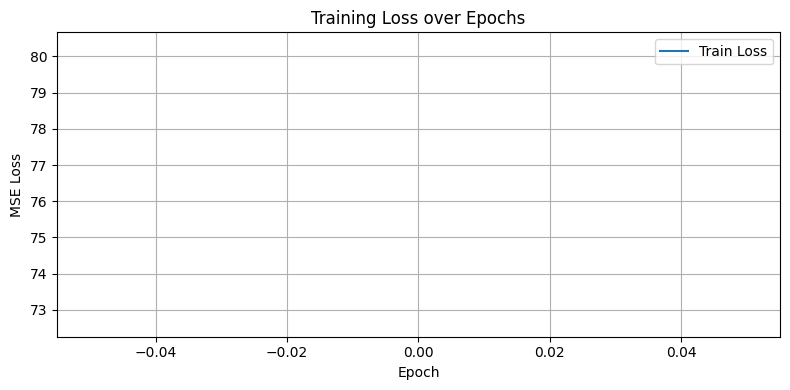

Epoch 3/1000, Train Loss: 80.8059, Val Loss: 25.6409, Best Val Loss: 25.6409
Epoch 4/1000, Train Loss: 76.6335, Val Loss: 20.8977, Best Val Loss: 20.8977


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import r2_score

# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Convert training and testing data to PyTorch tensors and move to device
X_tr = torch.from_numpy(X_train).float().to(device)  
X_vald = torch.from_numpy(X_val).float().to(device)  
X_te = torch.from_numpy(X_test).float().to(device)  
y_tr = torch.from_numpy(y_train).float().unsqueeze(1).to(device)  # Add extra dimension for compatibility
y_vald = torch.from_numpy(y_val).float().unsqueeze(1).to(device)
y_te = torch.from_numpy(y_test).float().unsqueeze(1).to(device)

# DataLoader for batching the data
batch_size = 64  # Define batch size
train_dataset = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)


# Define a fully connected neural network with ReLU activations and Dropout
dp = 0.05  # Dropout probability set to 5%
model = torch.nn.Sequential(
    torch.nn.Linear(37, 64),     # Input layer -> 64 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(64, 128),   # Hidden layer -> 128 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(128, 64),   # Hidden layer -> 64 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(64, 1)      # Output layer -> 1 value (regression)
).to(device)  # Move model to device (GPU or CPU)

# Define Mean Squared Error loss function
loss_fn = torch.nn.MSELoss(reduction='mean')
# Set learning rate and optimizer
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=0.0001)  # Adam optimizer with weight decay for regularization

# Early Stopping Parameter
patience = 20
best_val_loss = np.inf
epochs_no_improve = 0
n_epochs = 1000
loss_history = []
val_loss_history = []

for epoch in range(n_epochs):
    model.train()                           # Set model to training mode
    batch_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()               # Reset gradients
        y_pred = model(X_batch)             # Forward pass
        loss = loss_fn(y_pred, y_batch)     # Compute MSE loss
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Update weights
        batch_losses.append(loss.item())   
    loss_history.append(loss.item())    # Save loss value

    # calculate validation loss
    model.eval()                            # Set model to evaluation mode
    with torch.no_grad():
        y_val_pred = model(X_vald)           # Forward pass on validation set
        val_loss = loss_fn(y_val_pred, y_vald)  # Compute MSE loss on validation set
        val_loss_history.append(val_loss.item())
        
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}")
        
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
        
    # Update plot every 100 epochs
    if epoch % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(loss_history, label='Train Loss', color='tab:blue')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training Loss over Epochs')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
#print(loss_history)

Inference on the Train and test data without aleatoric uncertainty

In [6]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
model.train()
# Number of stochastic forward passes for MC Dropout
n_samples = 50

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred = torch.stack([model(X_tr) for i in range(n_samples)]).detach().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred = torch.stack([model(X_te) for i in range(n_samples)]).detach().numpy()

Plot the uncertainty interval for the NN with MC Dropout

R² on Train Data: 0.784
R² on Test Data: 0.767
Coverage: 86.00%


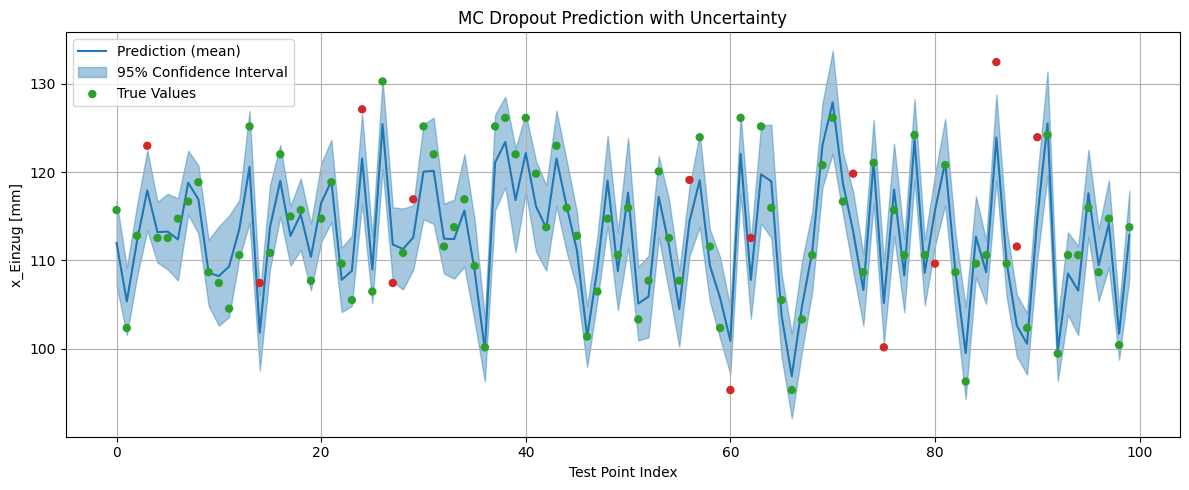

In [7]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred.mean(axis = 0)
y_train_Pred_std = y_train_pred.std(axis = 0)

# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred.mean(axis = 0)
y_test_pred_std = y_test_pred.std(axis = 0)

# Calculate R² score for the test data
r2_test = r2_score(y_te, y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean[random_indices] - 2 * mc_std[random_indices]
mc_upper_bound = mc_mean[random_indices] + 2 * mc_std[random_indices]

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test[random_indices] >= mc_lower_bound) & (y_test[random_indices] <= mc_upper_bound)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound, mc_upper_bound, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_te[random_indices].flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()